Algorithms to be tested which use segmentation based techniques.

In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
import pandas as pd
import numpy as np
import s3fs
import random

from library import lib_aws, esp, preprocess, visualization, metrics

import matplotlib.pyplot as plt
import matplotlib as mpl

In [12]:
# Opttions
pd.set_option('display.max_rows', 500)
mpl.rcParams['figure.figsize'] = (25,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Import the Data
- Import failure_df
    - Failures Not to use: `['Unknown', 'Stuck Pump', 'Low Production']`
- Import main data
- Preprocess the data
    - Resample
    - Scale

In [13]:
# Import failures
path = r's3://et-oasis/failure-esp/Oasis ESP Failure Analysis.xlsx'
failure_df = pd.read_excel(path)

# basic cleaning 
failure_df['WELL_NAME'] = failure_df['WELL_NAME'].apply(preprocess.node_clean)  # clean well names
failure_df['Reason For Pull'] = failure_df['Reason For Pull'].fillna('Unknown')  # fill in nan values
failure_df = failure_df[['WELL_NAME', 'Install Date', 'Start Date', 'Fail Date', 'Run Life (Days)', 'Reason For Pull']]  # change columns if need be
failure_df.rename(columns={'WELL_NAME': 'NodeID'}, inplace=True)  # modify col name
failure_df['Reason For Pull'] = failure_df['Reason For Pull'].map({'Grounded downhole':'Grounded Downhole'}).fillna(failure_df['Reason For Pull'])  # clean up typo

# Failures to skip
fail_drop = ['Unknown', 'Stuck Pump', 'Low Production']
failure_df = failure_df[~failure_df['Reason For Pull'].isin(fail_drop)]
failure_df.reset_index(inplace=True, drop=True)

fail_wells = list(failure_df.NodeID.unique())  # List of wells that are present in failure df
failure_df.sample(5)

NodeID Install Date Start Date  Fail Date  \
11     Wade Federal 5300 41-30 9B   2019-08-11 2019-08-12 2020-05-06   
44        Spratley 5494 34-13 11T   2018-12-28 2018-12-29 2019-11-04   
57         Kjorstad 5300 34-22 9B   2019-05-03 2019-05-04 2019-09-06   
43            Lite 5393 11-11 3BX   2018-12-11 2018-12-12 2019-11-08   
25  Seattle Federal 5200 42-35 7B   2019-06-20 2019-06-21 2020-01-25   

    Run Life (Days)    Reason For Pull  
11              268  Grounded Downhole  
44              310  Grounded Downhole  
57              125       Broken Shaft  
43              331      No Production  
25              218      No Production

In [14]:
%%time
# Import data
query = """
select * from m_esp_data
where "NodeID" in {}
""".format(tuple(fail_wells))

with lib_aws.PostgresRDS(db='esp-data') as engine:
    full_data = pd.read_sql(query, engine, parse_dates=['Date'])

wells_in_data = full_data.NodeID.unique()
full_data.sample(5)

Wall time: 2min 57s


NodeID                Date  MotorCurrent  \
2033029  Lewis Federal 5300 21-31 5B 2020-03-12 06:47:59          37.0   
266500          Berry 5493 44-7 14BX 2020-03-11 17:49:21          32.6   
2369462          Martin 5302 11-4 4B 2020-10-22 19:30:18           NaN   
345181          Berry 5493 44-7 15TX 2019-12-11 09:00:44          17.0   
3340023   Wade Federal 5300 41-30 9B 2020-01-12 16:47:28          22.0   

         Frequency  OutputAmps  OutputVolts     PIP     PDP  TubingPressure  \
2033029       54.0       242.0        422.0   735.0   130.0           240.0   
266500        62.0         NaN          NaN   502.7  4040.0           213.0   
2369462        NaN         NaN          NaN     NaN     NaN             NaN   
345181        63.0         NaN          NaN   419.0  4463.0           156.0   
3340023       63.0       140.0        504.0  1281.0     0.0           231.0   

         CasingPressure    PIT  MotorTemperature   XVib   YVib  
2033029           146.0  242.0             300.0  221.0  131.0  
266500            236.0  244.0             264.0    8.0    NaN  
2369462             NaN    NaN               NaN    NaN    NaN  
345181             99.0  240.0             263.0    5.0    NaN  
3340023           176.0  247.0             278.0   76.0   95.0

In [15]:
# Quick overview
print('List of wells in failures but not in main data\n',
      *(set(fail_wells) - set(wells_in_data)), sep='\n')



# get avg sampling rate for each well
data_info = (full_data.groupby('NodeID')
                      .agg({'Date': lambda x: np.mean(x.diff()/pd.Timedelta('1 min')),
                            'MotorCurrent': 'count'})
                      .rename(columns={'Date': 'Avg Sampling in Min', 'MotorCurrent': 'DataPoints'})
                      .round(2))

print('\n------\nAvg Sampling in the entire dataset {:.2f}'.format(data_info['Avg Sampling in Min'].mean()))
print('\n\nNote: Check data_info dataframe for well specific sampling')

List of wells in failures but not in main data

Seattle Federal 5200 42-35 8B
Crane Federal 5300 41-26H
Hanover Federal 5300 42-11 12B
Cook Federal 5300 41-12 10BX
Vaughn-Becky 5501 11-1B
Spratley 5494 44-13 3BX
Merritt 5693 11-24H
Spratley 5494 14-13 13T
Osprey 5401 44-23H

------
Avg Sampling in the entire dataset 16.55


Note: Check data_info dataframe for well specific sampling


## Preprocessing
- Resample the data: 1 hr
- Transfer Labels
- Visualize

In [16]:
%%time
# Resampling
# TODO: Check which columns to drop and use for analysis
data_resampled = full_data.copy() # create a copy
data_resampled.drop(columns=['OutputAmps', 'OutputVolts', 'YVib'], inplace=True) # drop these columns
data_resampled.set_index(['NodeID', 'Date'], inplace=True)  # set index
data_resampled.dropna(how='all', inplace=True)  # drop all rows where only nans present, will reduce it even further where we drop unnecessary columns
data_resampled.reset_index(inplace=True)

# Resampling
data_resampled = data_resampled.groupby('NodeID').resample('1H', on='Date').mean()
data_resampled.reset_index(inplace=True)
data_resampled.tail(5)

Wall time: 3.49 s


NodeID                Date  MotorCurrent  \
301574  Wade Federal 5300 41-30 9B 2020-05-07 09:00:00      0.000000   
301575  Wade Federal 5300 41-30 9B 2020-05-07 10:00:00      0.000000   
301576  Wade Federal 5300 41-30 9B 2020-05-07 11:00:00      0.000000   
301577  Wade Federal 5300 41-30 9B 2020-05-07 12:00:00      0.000000   
301578  Wade Federal 5300 41-30 9B 2020-05-07 13:00:00      6.714286   

        Frequency  PIP  PDP  TubingPressure  CasingPressure  PIT  \
301574   0.000000  0.0  0.0      192.166667          53.500  0.0   
301575   0.000000  0.0  0.0      190.937500           6.625  0.0   
301576   0.000000  0.0  0.0      190.833333           0.000  0.0   
301577   0.000000  0.0  0.0      192.500000           0.000  0.0   
301578   0.857143  0.0  0.0      189.357143           0.000  0.0   

        MotorTemperature  XVib  
301574               0.0   0.0  
301575               0.0   0.0  
301576               0.0   0.0  
301577               0.0   0.0  
301578               0.0   0.0

**Transferring Labels**

- Pick a `forecasting_delta` for each failure. For now we consider `15 days`. Change this if need be.
- Quick Steps in how its done:
    - `Start Date` to (`Fail Date` - `forecasting_delta`) --> Label as `Normal`
    - (`Fail Date` - `Forecasting_delta`) to `Fail Date` --> Label as `Reason to Pull`
    - `Fail Date` to (`Fail Date` + `1 day`)  -->  Label as `Actual + Reason to Pull`
    - Label everythng esle as `Drop`
- This gives us the a labeled dataset on which we can run our analysis and implement some splitting strategies
- Use the library function: `library.esp.label_esp_data()`
- Check docstring for more info

In [17]:
%%time
# Transferring Labels
esp.label_esp_data(data_resampled, 
                   failure_df, forecasting_delta='15 days',
                   verbose=0)  # Change to 1 to see the well specific code

Labeling Done
Wall time: 5.39 s


In [18]:
data_resampled.Label.value_counts()

Normal                      162789
Drop                        118560
Grounded Downhole             5849
Broken Shaft                  5415
No Production                 4212
Hole in Tubing                2888
Actual Grounded Downhole       581
Actual Broken Shaft            473
Actual No Production           454
Actual Hole in Tubing          358
Name: Label, dtype: int64

In [98]:
# PLot
# plot Specific wells
visualization.plot_features(df=data_resampled,
                      well_name='Jensen 5501 43-7 5B',
                      fail_col='Label',
                      zero_label = 'Normal',
                      feature_cols=['MotorCurrent','PIP', 'PDP', 'MotorTemperature'],
                      mov_avg=None)

**Final Cleanup**
- Drop rows with labels
    - `Drop` : Dont have info
    - `Actual Label` : Building a forecasting model so we dont need these labels


In [20]:
data = data_resampled.copy()
data = data[~data['Label'].str.contains('Drop')]  # Dropping labels Drop
data = data[~data['Label'].str.contains('Actual')]  # Dropping actual failures
data.reset_index(inplace=True, drop=True)
data.Label.value_counts()

Normal               162789
Grounded Downhole      5849
Broken Shaft           5415
No Production          4212
Hole in Tubing         2888
Name: Label, dtype: int64

## Normalizing the data

Library Class: `library.preprocess.Normalization`

A very important task will be on identifying how we normalize the data:

**Technique 1: Normalize the Entire Dataset**
- Normalize the data on the entire dataset. (This will include all wells and all datapoints)
- Once the scaler is trained. Save it and use it whenever needed (while in production)
- For Dev: `library.preprocess.Normalization.full_scaling()`

**Tehnique2: Well Specific Normalization**
- Build a custom scaling funcntion in a well specifc basis.
- This will save the max/min values for each KPI.
- And while scaling, fucntion will pull the correct max/min to scale the data or build a scaler.
- In production, use the scaler which is needed for each group.
- For Dev: `library.preprocess.Normalization.well_specific()`

**Technique3: Using Scaling in a pipeline**


In [21]:
columns_to_normalize = ['MotorCurrent', 'Frequency', 'PIP', 'PDP', 'TubingPressure', 'CasingPressure', 'PIT', 'MotorTemperature', 'XVib']  # columns which will be normalized
columns_to_keep = ['NodeID', 'Date', 'Label']  # additional columns we need in the dataset

# Well Specific Scaler
data_scaled_well = preprocess.Normalization.well_specific(dataset=data,
                                                         cols_norm=columns_to_normalize,
                                                         cols_keep=columns_to_keep)

data_scaled_well.sample(5)

Values Dropped in well: Jensen 5501 43-7 6B
Values Dropped in well: Spratley 5494 34-13 11T


NodeID                Date          Label  \
97884           Martin 5302 11-4 4B 2020-04-25 10:00:00         Normal   
129288     Om Erickson 5501 43-7 6B 2019-10-15 00:00:00         Normal   
85157   Lewis Federal 5300 21-31 5B 2020-05-28 22:00:00         Normal   
16931            Berry 5493 42-7 9B 2020-05-21 06:00:00  No Production   
114639  Oasis Meiers 5692 11-19 11T 2019-11-20 12:00:00         Normal   

        MotorCurrent  Frequency       PIP       PDP  TubingPressure  \
97884       0.724112   0.887370  0.410511  0.872721        0.444236   
129288      0.752893   0.769231  0.457435  0.719372        0.375900   
85157       0.919255   0.934722  0.068813  0.730109        0.814934   
16931       0.850000   0.929999  0.215068  0.826197        0.735156   
114639      0.724528   0.728745  0.860559  0.766034        0.387097   

        CasingPressure       PIT  MotorTemperature      XVib  
97884         0.232146  0.823510          0.826476  0.400000  
129288        0.073589  0.446456          0.708054  0.318761  
85157         0.183961  0.504915          0.814619  0.216250  
16931         0.172911  0.480186          0.632901  0.396825  
114639        0.188104  0.070588          0.423792  0.214286

In [22]:
# Well Full Scaling
data_scaled_full, trained_scaler = preprocess.Normalization.full_scaling(dataset=data,
                                                                         cols_norm=columns_to_normalize,
                                                                         cols_keep=columns_to_keep)

data_scaled_full.sample(5)

NodeID                Date           Label  \
52893         Drummond 5501 41-21 7B 2019-11-10 05:00:00          Normal   
66034            Jensen 5501 43-7 5B 2019-12-08 23:00:00          Normal   
102211        Mccauley 5501 14-4 8BX 2019-12-23 08:00:00  Hole in Tubing   
79025   Lewis Federal 5300 11-31 4BR 2020-03-01 07:00:00          Normal   
90640            Lite 5393 41-11 12T 2019-09-24 23:00:00          Normal   

        MotorCurrent  Frequency       PIP       PDP  TubingPressure  \
52893       0.176109   0.823077  0.176452  0.000000        0.203609   
66034       0.185771   0.769231  0.240413  0.000000        0.228811   
102211      0.205534   0.879487  0.125902  0.000000        0.228630   
79025       0.203186   0.891469  0.167932  0.812542        0.164331   
90640       0.131313   0.908974  0.077836  0.813311        0.130026   

        CasingPressure       PIT  MotorTemperature      XVib  
52893         0.030389  0.481871          0.783846  0.181395  
66034         0.041333  0.475771          0.782698  0.196705  
102211        0.033944  0.475771          0.807710  0.425000  
79025         0.057667  0.494070          0.798531  0.004651  
90640         0.089417  0.483734          0.715695  0.007946

Finally we have 3 datasets we can use:
- `data` : Un-scaled data
- `data_scaled_well` : Data has been scaled in a well specific basis
- `data_scaled_full` : The entire dataset has been scaled separately

# Testing Algorithms

We will use Tree based algorithms in this dataset.

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, Normalizer

In [106]:
"""
Helper functions
"""
# rolling mean func
def get_agg(df, freq, time_col='Date', well_col = 'NodeID'):
    
    frames = []
    
    for well in df[well_col].unique():
        temp_df = df[df[well_col] == well].copy()
        temp_df.set_index(time_col, inplace=True)
        temp_df = temp_df.rolling(freq).mean()
#         temp_df = temp_df.add_prefix(freq+'_')
        temp_df[well_col] = well
        temp_df.reset_index(inplace=True)
        frames.append(temp_df)
        
    rolled_df = pd.concat(frames)
    rolled_df.reset_index(inplace=True, drop=True)
    
    return rolled_df

# Simple model testing function
# USe with well split to get quick metrics
def simple_model_test(train_data, test_data, cols, model, label_col='Label', agg=None):
    """
    Can use with Well SPlit Data
    """
    print('\n------------------')
    if agg is not None:
        # Aggregate the data
        train = pd.concat([get_agg(train_data, freq=agg).set_index(['NodeID', 'Date']), train_data.set_index(['NodeID', 'Date'])[label_col]], axis=1)
        test = pd.concat([get_agg(test_data, freq=agg).set_index(['NodeID', 'Date']), test_data.set_index(['NodeID', 'Date'])[label_col]], axis=1)
        print(f'Aggregation of {agg} Done')
    else:
        train = train_data.copy()
        test = test_data.copy()

    # get training data
    X_train = (train[cols].copy()
               .dropna() # dropna
               .sample(frac=1)  # shuffle
               .reset_index(drop=True))
    y_train = X_train.pop(label_col)

    # get testing data
    X_test = (test[cols].copy()
              .dropna()
              .reset_index(drop=True))
    y_test = X_test.pop(label_col)

    # fit the model
    model.fit(X_train, y_train)
    print("Model Trained")
    y_pred = model.predict(X_test)
    print("Predictions Done\n")
    # metrics
    if issubclass(model.classes_.dtype.type, np.integer):
        cl = None
    else:
        cl = model.classes_
    
    metrics.quick_metrics(y_test, y_pred, cl)
    
    return model

# plot feature importance
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

The following strategies have been identified for splitting the data:

**Shuffle Split**
- Use the `train_test_split` funtion from `sklearn.preprocessing`
- This will lead to overfitting 
- Will give much better results than what we may see in real-time
- May work for segmented techniques 

**Split By well**
- `library.preprocess.split_by_well`
- Split the data by wells
- Both train and test should include all the failures
- This method will be preferred
- Good results here will imply the algo can be generalized for differenet wells
- Will also tell us whether our Normalizing strategy works
- Should work really well for real-time data

**Time Series Split**
- Split the data by time
- Best method for gerneralizing the model and avoid overfitting
- However for our current dataset this will not work as most of the failures are occurring in the end

## Forecast All Failures

**Model 1**
- Data: `data`
- Split Strategy: `library.preprocess.split_by_well`
- Model: Pipeline with Scaler and Extra Tree classifier

In [25]:
# Split the data
train_data, test_data = preprocess.split_by_well(data, 
                                                 no_of_wells=2,
                                                 fail_col='Label',
                                                 zero_label='Normal',
                                                 verbose=1)

Label Distribution:
----------
                    Train   Test
Normal             128670  34119
Grounded Downhole    4766   1083
Broken Shaft         4693    722
No Production        3129   1083
Hole in Tubing       2166    722
Wells Used in Test-Set:
---------
Kjorstad 5300 34-22 9B
Oasis Meiers 5692 11-19 11T
Berry 5493 42-7 8T
Spratley 5494 14-13 16BX
Mccauley 5501 14-4 8BX
Mccauley 5601 41-34 6B
Dawson 5494 42-12 3B
Berry 5493 42-7 9B
NAN value Distribution in %:
-------------
                  Train  Test
NodeID             0.00  0.00
Date               0.00  0.00
MotorCurrent       3.14  2.62
Frequency          2.51  2.62
PIP                3.14  2.62
PDP                3.14  2.62
TubingPressure    13.62  2.62
CasingPressure     4.42  2.62
PIT               12.33  2.62
MotorTemperature   3.14  2.62
XVib              12.33  2.62
Label              0.00  0.00



------------------
Model Trained
Predictions Done

Weighted Metrics
Precision : 83.24
Recall: 78.03
F-score: 79.57

Macro Metrics
Precision : 37.42
Recall: 24.95
F-score: 21.80

Classification Report
                   precision    recall  f1-score   support

     Broken Shaft       0.00      0.00      0.00       721
Grounded Downhole       0.08      0.35      0.12      1077
   Hole in Tubing       0.89      0.05      0.09       716
    No Production       0.00      0.00      0.00      1083
           Normal       0.90      0.85      0.88     33143

         accuracy                           0.78     36740
        macro avg       0.37      0.25      0.22     36740
     weighted avg       0.83      0.78      0.80     36740



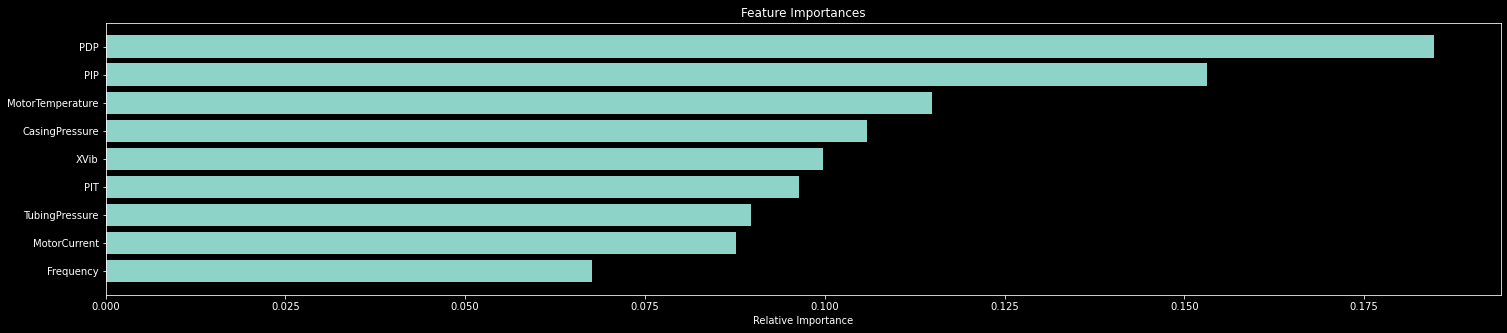

In [33]:
feature_cols = ['MotorCurrent', 'Frequency', 'PIP', 'PDP', 'TubingPressure', 'CasingPressure', 'PIT', 'MotorTemperature', 'XVib', 'Label']

# Model
scaler = MinMaxScaler() # Define Scaler
et_params ={ 'class_weight': 'balanced', 'verbose': 0}
et = ExtraTreesClassifier(**et_params)
model_1 = Pipeline([
    ('scaler', scaler),
    ('etc', et)
])

# Test
trained_model =  simple_model_test(train_data, test_data, cols=feature_cols, model=model_1, label_col='Label', agg=None)

plot_feature_importance(trained_model[1], feature_cols)  # Use that part of the pipeline which has the model

**Variant - 1**

- Data: `data_scaled_well` and `data_scaled_full`
- Model: Extra-Tree-Classifier

In [36]:
# Split the data
train_data, test_data = preprocess.split_by_well(data_scaled_full, 
                                                 no_of_wells=2,
                                                 fail_col='Label',
                                                 zero_label='Normal',
                                                 verbose=1)

Label Distribution:
----------
                    Train   Test
Normal             120067  23985
Broken Shaft         4614    722
Grounded Downhole    3639   1081
No Production        3410    600
Hole in Tubing       1798    719
Wells Used in Test-Set:
---------
Spratley 5494 34-13 9T
Kjorstad Federal 5300 14-27 11BX
Wade Federal 5300 41-30 9B
Dixon 5602 42-34 4B
Lewis Federal 5300 21-31 5B
Mccauley 5601 41-34 6B
Lite 5393 31-11 10T
Lite 5393 31-11 6T
NAN value Distribution in %:
-------------
                  Train  Test
NodeID              0.0   0.0
Date                0.0   0.0
Label               0.0   0.0
MotorCurrent        0.0   0.0
Frequency           0.0   0.0
PIP                 0.0   0.0
PDP                 0.0   0.0
TubingPressure      0.0   0.0
CasingPressure      0.0   0.0
PIT                 0.0   0.0
MotorTemperature    0.0   0.0
XVib                0.0   0.0



------------------
Model Trained
Predictions Done

Weighted Metrics
Precision : 78.75
Recall: 87.98
F-score: 82.92

Macro Metrics
Precision : 21.67
Recall: 20.30
F-score: 19.49

Classification Report
                   precision    recall  f1-score   support

     Broken Shaft       0.00      0.00      0.00       722
Grounded Downhole       0.00      0.00      0.00      1081
   Hole in Tubing       0.02      0.00      0.00       719
    No Production       0.18      0.02      0.04       600
           Normal       0.88      0.99      0.94     23985

         accuracy                           0.88     27107
        macro avg       0.22      0.20      0.19     27107
     weighted avg       0.79      0.88      0.83     27107



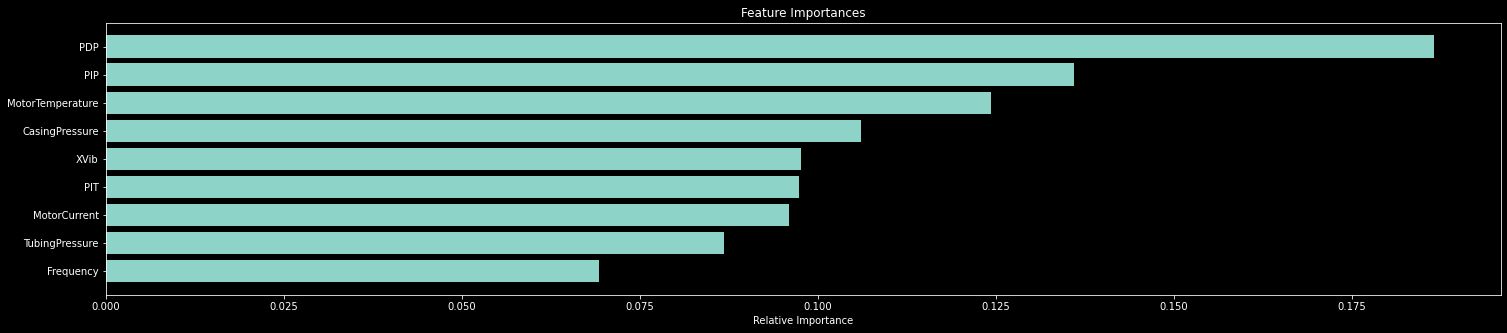

In [37]:
feature_cols = ['MotorCurrent', 'Frequency', 'PIP', 'PDP', 'TubingPressure', 'CasingPressure', 'PIT', 'MotorTemperature', 'XVib', 'Label']

et_params ={ 'class_weight': 'balanced', 'verbose': 0}
model_2 = ExtraTreesClassifier(**et_params)

# Test
trained_model =  simple_model_test(train_data, test_data, cols=feature_cols, model=model_2, label_col='Label', agg=None)

plot_feature_importance(trained_model, feature_cols)  

**Model 2**
- Data: `data`
- Split Strategy: `sklearn.model_selection.train_test_split`
- Model: Pipeline with Scaler and Extra Tree classifier

Weighted Metrics
Precision : 98.12
Recall: 98.15
F-score: 98.09

Macro Metrics
Precision : 96.88
Recall: 89.20
F-score: 92.78

Classification Report
                   precision    recall  f1-score   support

     Broken Shaft       0.95      0.80      0.87      1334
Grounded Downhole       0.96      0.86      0.90      1180
   Hole in Tubing       0.98      0.94      0.96       629
    No Production       0.97      0.87      0.92      1003
           Normal       0.98      1.00      0.99     36013

         accuracy                           0.98     40159
        macro avg       0.97      0.89      0.93     40159
     weighted avg       0.98      0.98      0.98     40159



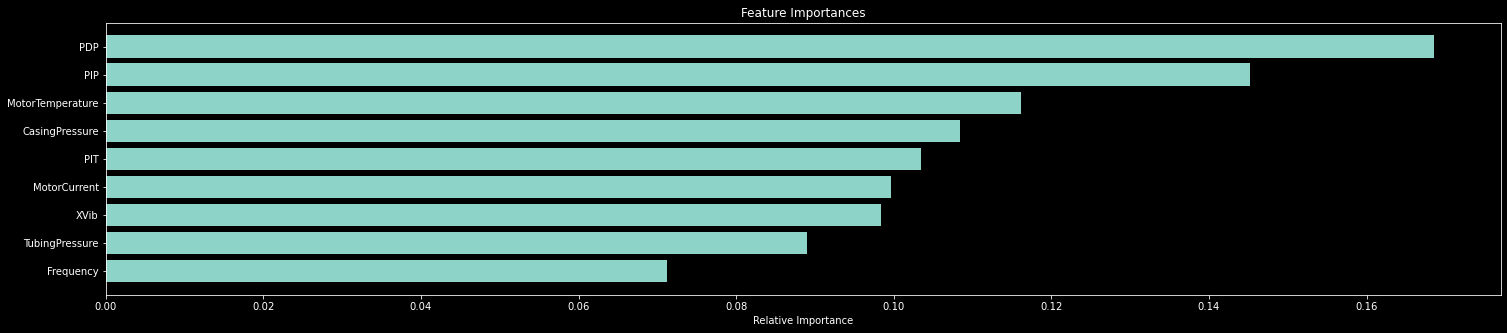

In [50]:
feature_cols = ['MotorCurrent', 'Frequency', 'PIP', 'PDP', 'TubingPressure', 'CasingPressure', 'PIT', 'MotorTemperature', 'XVib']

data_temp = data.dropna(how='any', subset=feature_cols).copy()

X = data_temp[feature_cols]
Y = data_temp['Label']

del data_temp

# SKlearn train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, stratify=Y)

# Model
scaler = MinMaxScaler() # Define Scaler
et_params ={ 'class_weight': 'balanced', 'verbose': 0}
et = ExtraTreesClassifier(**et_params)
model_2 = Pipeline([
    ('scaler', scaler),
    ('etc', et)
])

model_2.fit(X_train, y_train)  # fit the model
y_pred = model_2.predict(X_test)  # make predictions

metrics.quick_metrics(y_test, y_pred, model_2.classes_)  # get metrics

plot_feature_importance(model_2[1], feature_cols)  # Use that part of the pipeline which has the model

## Forecasting Class Specific

In [52]:
failure_distribution = data.groupby('Label')['NodeID'].agg(['unique'])
display(failure_distribution)
display(data.Label.value_counts())

unique
Label                                                               
Broken Shaft       [Berry 5493 41-7 6B, Berry 5493 44-7 14BX, Ber...
Grounded Downhole  [Berry 5493 42-7 8T, Crane Federal 5300 14-27 ...
Hole in Tubing     [Drummond 5501 41-21 7B, Jensen 5501 11-18 4B,...
No Production      [Berry 5493 42-7 9B, Crane Federal 5300 14-27 ...
Normal             [Berry 5493 41-7 6B, Berry 5493 42-7 8T, Berry...

Normal               162789
Grounded Downhole      5849
Broken Shaft           5415
No Production          4212
Hole in Tubing         2888
Name: Label, dtype: int64

In [99]:
# Get the failure we need
failure_type = 'Grounded Downhole'
dataset = data.copy()

failure_distribution = dataset.groupby('Label')['NodeID'].agg(['unique'])
wells = failure_distribution.loc[failure_type]['unique']  # list of wells that have grounded downhole as a failure

print(f'No of wells in with this failure {len(wells)}')
data_gd = dataset[dataset.NodeID.isin(wells)].copy()
data_gd.reset_index(inplace=True, drop=True)
print("-------------\nActual Label Distribution:")
display(data_gd.Label.value_counts())

# CReate binary labels 1 - Specific failure, 0 - Everything else
data_gd['LabelBin'] = data_gd['Label'].map(lambda x: failure_type if x == failure_type else 'Normal' )
print("Binary Labels: ")
display(data_gd['LabelBin'].value_counts())

No of wells in with this failure 17
-------------
Actual Label Distribution:


Normal               60468
Grounded Downhole     5849
Hole in Tubing         722
No Production          722
Name: Label, dtype: int64

Binary Labels: 


Normal               61912
Grounded Downhole     5849
Name: LabelBin, dtype: int64

In [101]:
print("Wells that may have errors:")
x = data_gd.groupby('NodeID').mean()
x[x==0].dropna(how='all').dropna(axis=1, how='all')

Wells that may have errors:


PIP  PDP  PIT  MotorTemperature  XVib
NodeID                                                           
Berry 5493 42-7 8T          0.0  0.0  0.0               0.0   0.0
Jensen 5501 43-7 5B         NaN  0.0  NaN               NaN   NaN
Lite 5393 41-11 11B         NaN  0.0  NaN               NaN   NaN
Thorlaksen 11-14H           NaN  0.0  NaN               NaN   NaN
Wade Federal 5300 41-30 9B  NaN  0.0  NaN               NaN   NaN

In [97]:
# Visualize the data
# PLot
# plot Specific wells
visualization.plot_features(df=data_gd,
                          well_name='Jensen 5501 43-7 5B',
                          fail_col='LabelBin',
                          zero_label = 'Normal',
                          feature_cols=['PIP', 'PDP', 'PIT', 'MotorTemperature', 'XVib'],
                          mov_avg='7D')

In [102]:
# if you ant to frop wells or features
wells_to_drop = ['Berry 5493 42-7 8T', 'Crane Federal 5300 14-27 3B']
data_gd = data_gd[~data_gd.NodeID.isin(wells_to_drop)]
data_gd.reset_index(inplace=True, drop=True)

In [103]:
# Split the data
# Split the data
train_data, test_data = preprocess.split_by_well(data_gd, 
                                                 no_of_wells=3,
                                                 fail_col='LabelBin',
                                                 zero_label='Normal',
                                                 verbose=1)

Label Distribution:
----------
                   Train    Test
Normal             40140  9432.0
Grounded Downhole   4332  1083.0
Hole in Tubing       361   361.0
No Production        361     NaN
Wells Used in Test-Set:
---------
Dixon 5602 42-34 4B
Martin 5302 11-4 4B
Dawson 5494 42-12 5B
NAN value Distribution in %:
-------------
                  Train  Test
NodeID             0.00  0.00
Date               0.00  0.00
MotorCurrent       5.23  3.77
Frequency          3.23  3.77
PIP                5.23  3.77
PDP                5.23  3.77
TubingPressure    13.37  3.77
CasingPressure     9.25  3.77
PIT                9.35  3.77
MotorTemperature   5.23  3.77
XVib               9.35  3.77
Label              0.00  0.00
LabelBin           0.00  0.00



------------------
Model Trained
Predictions Done

Weighted Metrics
Precision : 90.84
Recall: 90.64
F-score: 86.31

Macro Metrics
Precision : 91.75
Recall: 50.65
F-score: 48.83

Classification Report
                   precision    recall  f1-score   support

Grounded Downhole       0.93      0.01      0.03       992
           Normal       0.91      1.00      0.95      9474

         accuracy                           0.91     10466
        macro avg       0.92      0.51      0.49     10466
     weighted avg       0.91      0.91      0.86     10466



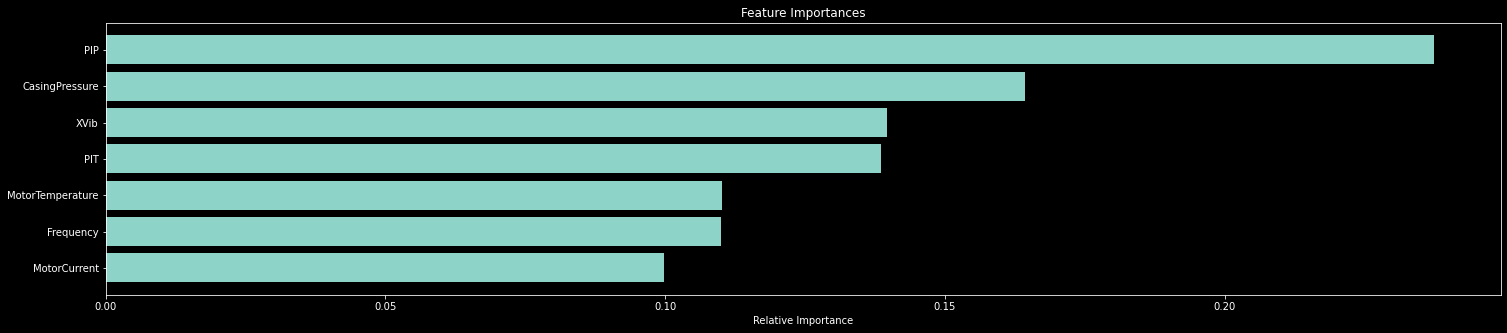

In [114]:
feature_cols = ['MotorCurrent', 'Frequency', 'PIP', 'CasingPressure', 'PIT', 'MotorTemperature', 'XVib', 'LabelBin']

# Model
scaler = StandardScaler() # Define Scaler
et_params ={ 'class_weight': 'balanced', 'verbose': 0}
et = ExtraTreesClassifier(**et_params)
model_1 = Pipeline([
    ('scaler', scaler),
    ('etc', et)
])

# Test
trained_model =  simple_model_test(train_data, test_data, 
                                   cols=feature_cols, 
                                   model=model_1, 
                                   label_col='LabelBin', 
                                   agg=None) 

plot_feature_importance(trained_model[1], feature_cols)  # Use that part of the pipeline which has the model

PIP  PDP  PIT  MotorTemperature  XVib
NodeID                                                           
Berry 5493 42-7 8T          0.0  0.0  0.0               0.0   0.0
Jensen 5501 43-7 5B         NaN  0.0  NaN               NaN   NaN
Lite 5393 41-11 11B         NaN  0.0  NaN               NaN   NaN
Thorlaksen 11-14H           NaN  0.0  NaN               NaN   NaN
Wade Federal 5300 41-30 9B  NaN  0.0  NaN               NaN   NaN